In [0]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import datetime
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


import scipy
from scipy import hstack


from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.feature_selection.univariate_selection import SelectKBest, f_regression

**Loading data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/MercariCS')

In [4]:
X_train = scipy.sparse.load_npz("train_final.npz")
y_train = np.load('y_train.npy')

X_cv = scipy.sparse.load_npz("cv_final.npz")
y_cv = np.load('y_cv.npy')

# X_test = scipy.sparse.load_npz("test_final.npz")
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((1332967, 48049), (1332967,), (148108, 48049), (148108,))

### 6.3. SVM Regression

#### Hyper parameter tuning using RandomizedSearchCV

RMSLE for C= 0.01 is 1.199926186837584
RMSLE for C= 0.03 is 1.0373687259431916
RMSLE for C= 0.1 is 0.7031124570842185
RMSLE for C= 0.3 is 0.45763721721801703
RMSLE for C= 1 is 0.9825724712557466
RMSLE for C= 3 is 0.6889839235210923
RMSLE for C= 10 is 0.7062493308619081


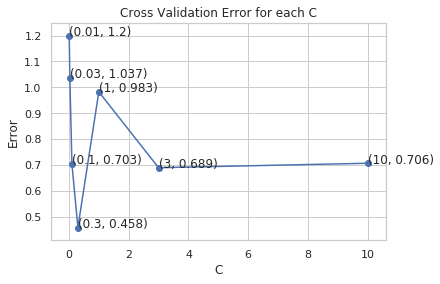

In [7]:
c_param = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
cv_rmsle_array=[]

for i in c_param:
    model = SVR(C=i, max_iter=200)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_err = sqrt(mse(y_cv, preds_cv))
    cv_rmsle_array.append(cv_err)

    print('RMSLE for C=',i, 'is', cv_err)

best_C = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(c_param, cv_rmsle_array)
ax.scatter(c_param, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((c_param[i],np.round(txt,3)), (c_param[i],cv_rmsle_array[i]))
plt.title("Cross Validation Error for each C")
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

#### Training and testing using best parameters 

In [9]:
best_C = c_param[best_C]
print('Best C: ', best_C)
model = SVR(C=best_C, max_iter=200)
model.fit(X_train, y_train)

Best C:  0.3


SVR(C=0.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=200, shrinking=True, tol=0.001, verbose=False)

In [10]:
svr_preds_tr = model.predict(X_train)
svr_preds_cv = model.predict(X_cv)
print('Train RMSLE:', sqrt(mse(y_train, svr_preds_tr)))

svr_rmsle = sqrt(mse(y_cv, svr_preds_cv))
print("Cross validation RMSLE: ", svr_rmsle)

Train RMSLE: 0.44156303699190574
Cross validation RMSLE:  0.45763721721801703


### 6.4. RandomForest Regression

#### Hyper parameter tuning using RandomizedSearchCV

RMSLE for N=10 is 0.487657647189664	 elapsed time:0:46:21.136700
RMSLE for N=20 is 0.47260697582126654	 elapsed time:2:02:11.229545


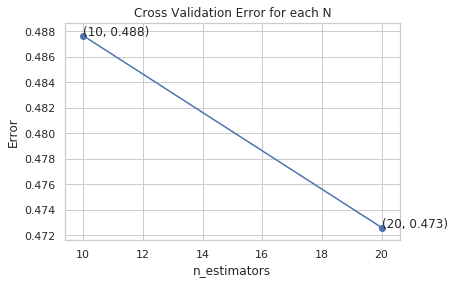

In [25]:
dt = datetime.datetime #to track time

estimators = [10, 20]
cv_rmsle_array=[]
t0 = dt.now()
for i in estimators:
    model = RandomForestRegressor(n_estimators=i, min_samples_split=10, max_features='sqrt', max_samples=0.9, random_state=42)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_err = sqrt(mse(y_cv, preds_cv))
    cv_rmsle_array.append(cv_err)

    print (f'RMSLE for N={i} is {cv_err}\t elapsed time:{dt.now() - t0}')

best_N = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(estimators, cv_rmsle_array)
ax.scatter(estimators, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((estimators[i],np.round(txt,3)), (estimators[i],cv_rmsle_array[i]))
plt.title("Cross Validation Error for each N")
plt.xlabel("n_estimators")
plt.ylabel("Error")
plt.show()

**Training RandomForest Regressor with higher values of n_estimators was taking tremendous amount of time without giving any results. Due to this reason, we have trained it with less number of estimators. The above code itself took approx. 3 hrs and hence, we did not train further.**

#### Training and testing using best parameters 

In [ ]:
best_N = estimators[best_N]
print('Best n_estimators: ', best_N)
model = RandomForestRegressor(n_estimators=best_N, min_samples_split=10, max_features='sqrt', max_samples=0.9, random_state=42)
model.fit(X_train, y_train)

In [0]:
# X_test = scipy.sparse.load_npz("test_final.npz")

In [ ]:
rf_preds_tr = model.predict(X_train)
rf_preds_cv = model.predict(X_cv)
# rf_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mse(y_train, rf_preds_tr)))

rf_rmsle = sqrt(mse(y_cv, rf_preds_cv))
print("Cross validation RMSLE: ", rf_rmsle)

### 6.5. LightGBM Regression

#### Hyper parameter tuning using RandomizedSearchCV

In [0]:
lgb_model = LGBMRegressor(subsample=0.9)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(200, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)
lgb_random = lgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122, score=(train=-0.268, test=-0.439), total= 5.4min
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122, score=(train=-0.272, test=-0.444), total= 5.6min
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.0min remaining:    0.0s


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122, score=(train=-0.266, test=-0.434), total= 5.6min
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.2min remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123, score=(train=-0.313, test=-0.355), total= 7.6min
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 26.3min remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123, score=(train=-0.314, test=-0.354), total= 7.8min
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.6min remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123, score=(train=-0.315, test=-0.353), total= 7.7min
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 42.9min remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149, score=(train=-0.368, test=-0.369), total= 2.3min
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 45.4min remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149, score=(train=-0.368, test=-0.369), total= 2.3min
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 47.9min remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149, score=(train=-0.368, test=-0.368), total= 2.3min
[CV] colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 50.5min remaining:    0.0s


[CV]  colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=-0.329, test=-0.360), total= 2.8min
[CV] colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 
[CV]  colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=-0.330, test=-0.360), total= 3.0min
[CV] colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 
[CV]  colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=-0.329, test=-0.358), total= 2.9min
[CV] colsample_bytree=0.29122914019

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 107.3min finished


In [0]:
df1 = pd.DataFrame(lgb_random.cv_results_)
df1[['param_learning_rate', 'param_n_estimators', 'param_num_leaves', 'param_max_depth', 'param_min_child_weight', 'param_colsample_bytree', 'mean_train_score', 'mean_test_score']]

,param_learning_rate,param_n_estimators,param_num_leaves,param_max_depth,param_min_child_weight,param_colsample_bytree,mean_train_score,mean_test_score
0,0.950714,1244,122,12,1.55938,0.37454,-0.268712,-0.438865
1,0.0999749,1323,123,12,1.73235,0.445833,-0.313804,-0.354006
2,0.0205845,1005,149,3,1.444,0.708073,-0.368029,-0.368651
3,0.183405,452,108,13,1.22331,0.181825,-0.329229,-0.359530
4,0.611853,899,34,11,0.0933313,0.291229,-0.318427,-0.371338
5,0.785176,1467,83,4,0.764924,0.45607,-0.337573,-0.371254
6,0.85994,366,37,8,0.341048,0.466763,-0.344313,-0.380979
7,0.965632,764,149,3,0.770833,0.948886,-0.348773,-0.364846
8,0.440152,975,194,8,1.21999,0.684233,-0.308797,-0.361790
9,0.391061,1225,153,3,1.32504,0.173365,-0.353940,-0.362636


In [0]:
best_params = lgb_random.best_params_
print(best_params)

{'colsample_bytree': 0.44583275285359114, 'learning_rate': 0.09997491581800289, 'max_depth': 12, 'min_child_weight': 1.7323522915498704, 'n_estimators': 1323, 'num_leaves': 123}


#### Training and testing using best parameters 

In [0]:
model = LGBMRegressor(**best_params, subsample=0.9, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.44583275285359114, importance_type='split',
              learning_rate=0.09997491581800289, max_depth=12,
              min_child_samples=20, min_child_weight=1.7323522915498704,
              min_split_gain=0.0, n_estimators=1323, n_jobs=-1, num_leaves=123,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)

In [0]:
X_cv = scipy.sparse.load_npz("cv_final.npz")
y_cv = np.load('y_cv.npy')

X_test = scipy.sparse.load_npz("test_final.npz")

In [0]:
lgb_preds_tr = model.predict(X_train)
lgb_preds_cv = model.predict(X_cv)
lgb_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mse(y_train, lgb_preds_tr)))

lgb_rmsle = sqrt(mse(y_cv, lgb_preds_cv))
print("Cross validation RMSLE: ", lgb_rmsle)

Train RMSLE: 0.3197898252767807
Cross validation RMSLE:  0.42423139030835477


**Creating submission file**

In [0]:
submission_df = pd.read_csv('ridge_submission.csv')

submission_df['price'] = np.exp(lgb_preds_te) - 1

submission_df.to_csv('lgb_submission.csv', index=False)

## Summary

In [3]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Model", "Feature Space", "Train_RMSLE", "Validation_RMSLE", "Kaggle_RMSLE(Public)"]
x.add_row(["Ridge", "FeatureEngg + cat_OHE + text_TFIDF", "0.38345", "0.44153", "0.45444"])
x.add_row(["SVR", "48Kbest text&cat + Ridge Preds + MNB Preds", "0.44156", "0.45764", "-"])
x.add_row(["LightGBM", "48Kbest text&cat + Ridge Preds + MNB Preds", "0.31979", "0.42423", "0.45823"])

print(x)

+----------+--------------------------------------------+-------------+------------------+----------------------+
|  Model   |               Feature Space                | Train_RMSLE | Validation_RMSLE | Kaggle_RMSLE(Public) |
+----------+--------------------------------------------+-------------+------------------+----------------------+
|  Ridge   |     FeatureEngg + cat_OHE + text_TFIDF     |   0.38345   |     0.44153      |       0.45444        |
|   SVR    | 48Kbest text&cat + Ridge Preds + MNB Preds |   0.44156   |     0.45764      |          -           |
| LightGBM | 48Kbest text&cat + Ridge Preds + MNB Preds |   0.31979   |     0.42423      |       0.45823        |
+----------+--------------------------------------------+-------------+------------------+----------------------+


- **We are able to get pretty decent results with ML models with feature engineering and standard text vectorization.**

- **In order to get more accurate predictions, we should try Deep Learning models.**